In [1]:
import copy

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import normalize
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 4-layer NN, 1-dim input layer, 2 hidden layers with 12-dim and 1 output layer with 1-dim
        self.net = nn.Sequential(
            nn.Linear(1,19),
            nn.Tanh(),
            nn.Linear(19,19),
            nn.Tanh(),
            nn.Linear(19,19),
            nn.Tanh(),
            nn.Linear(19,1)
        )
    def forward(self,x):
        return self.net(x)

In [2]:
# sine example (NOT WORKING)
def g(x):
    return torch.cos(x)

def f(t,x,y,z):
    T = 2
    sigma = 1
    mu = 0.2
    d = 1
    a_1 = torch.cos(x)*(torch.exp((T-t)/2)+sigma**2/2)+(mu*torch.sin(x))
    a_2 = torch.exp((T-t)/2)
    a_3 = 1/2*(torch.sin(x)*torch.cos(x)*torch.exp(T-t))**2
    a_4 = 0.5*y**2*z**2
    result = a_1*a_2 - a_3 +a_4
    return result

def F(t,x,y,z,delta_t,dWt):

    cost = y - f(t,x,y,z)*delta_t +z *dWt
    
    return cost

def g_prime(x):
    return -1*torch.sin(x)

def true_u(t,x):
    return torch.exp((2-t)/2)*g(x)
def u_prime(t,x):
    return torch.exp((2-t)/2)*g_prime(x)

In [3]:
def g(x):
    
    result = 1- (1/(1.+torch.exp(1+x)))
    return result

def f(t,x,y,z):
    return (y - 1.5)*z


def true_u(t,x):
    return 1-(1./(1+torch.exp(t+x)))
def F(t,x,y,z,delta_t,dWt):

    cost = y - f(t,x,y,z)*delta_t +z *dWt
    
    return cost
t = torch.linspace(0,1,101,dtype = torch.float32)
dt = t[1]-t[0] 
eta = 0.005
# total updates for gradient descent
N_epoch = 1000
# batch_size
N_MC = 256*4
#BM for each iteration
BM_mat = torch.sqrt(dt) * np.random.normal(size = (N_MC,len(t)-1))
BM_mat = BM_mat.to(t.dtype)

In [4]:
X_mat= torch.zeros((N_MC,len(t)))
X_mat[:,0] = torch.Tensor(np.random.uniform(-3,3,N_MC))

In [44]:
mu = 0;sigma = 1
for i in range(1,len(t)):
    X_mat[:,i] = X_mat[:,i-1]+mu*dt +sigma *BM_mat[:,i-1]

In [46]:
# train NN each time point
# create a list of NN to estimate U(x; )at each time ti
trained_U  = [None] * len(t)
# U_n is known so our approximation is exact
trained_U[-1] = g

# train NN each time point

for i in range(len(t)-1,0,-1):
    # reset your NNs
    if i == len(t)-1:
        NN_1 = Model()
        N_epoch = 3000
    else:
        NN_1 = copy.deepcopy(trained_U[i])
        N_epoch = 1000

    opt = torch.optim.Adam(NN_1.parameters(),lr = eta)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=250, gamma=0.1)
    for n in range(0,N_epoch):
        x_next = X_mat[:,i]
        U_next=torch.squeeze(trained_U[i](torch.unsqueeze(x_next,1)))

        # get x_{i-1}, U_{i-1}
        x_now = X_mat[:,i-1]
        x_now = x_now.clone().detach().requires_grad_(True)
        U_hat = torch.squeeze(NN_1(torch.unsqueeze(x_now,1)))
        Dx_hat =  torch.squeeze(torch.autograd.grad(U_hat.sum(),x_now,create_graph = True)[0])
        F_hat =  F(t[i-1],x_now,U_hat,Dx_hat,dt,BM_mat[:,i-1])
        Loss = torch.mean((U_next - F_hat)**2)
        Loss.backward()
        opt.step()
        opt.zero_grad()
        if n%100 == 0:
            print("Epoch: " + str(n))
            print("Loss: " + str(round(Loss.detach().item(),6)))

            # add your trained NN for i-1 step to your list of NN}
    trained_U[i-1] = copy.deepcopy(NN_1)
    print(i)




Epoch: 0
Loss: 0.307307
Epoch: 100
Loss: 3.6e-05
Epoch: 200
Loss: 1.2e-05
Epoch: 300
Loss: 4e-06
Epoch: 400
Loss: 3e-06
Epoch: 500
Loss: 2e-06
Epoch: 600
Loss: 2e-06
Epoch: 700
Loss: 2e-06
Epoch: 800
Loss: 2e-06
Epoch: 900
Loss: 1e-06
Epoch: 1000
Loss: 1e-06
Epoch: 1100
Loss: 1e-06
Epoch: 1200
Loss: 1e-06
Epoch: 1300
Loss: 1e-06
Epoch: 1400
Loss: 1e-06
Epoch: 1500
Loss: 1e-06
Epoch: 1600
Loss: 1e-06
Epoch: 1700
Loss: 1e-06
Epoch: 1800
Loss: 0.0
Epoch: 1900
Loss: 0.0
Epoch: 2000
Loss: 0.0
Epoch: 2100
Loss: 0.0
Epoch: 2200
Loss: 0.0
Epoch: 2300
Loss: 0.0
Epoch: 2400
Loss: 0.0
Epoch: 2500
Loss: 0.0
Epoch: 2600
Loss: 0.0
Epoch: 2700
Loss: 0.0
Epoch: 2800
Loss: 0.0
Epoch: 2900
Loss: 0.0
100
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 0.0
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
99
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 4

Epoch: 900
Loss: 0.0
65
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 1e-06
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 2e-06
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
64
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 0.0
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 1e-06
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
63
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 1e-06
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
62
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 1e-06
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 2e-06
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
61
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 1e-06
Epoch

27
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 2e-06
Epoch: 500
Loss: 0.0
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
26
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 1e-06
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 0.0
Epoch: 600
Loss: 3e-06
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 1e-06
25
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 0.0
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 0.0
Epoch: 900
Loss: 0.0
24
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 0.0
Epoch: 600
Loss: 0.0
Epoch: 700
Loss: 0.0
Epoch: 800
Loss: 1e-05
Epoch: 900
Loss: 0.0
23
Epoch: 0
Loss: 3e-06
Epoch: 100
Loss: 0.0
Epoch: 200
Loss: 0.0
Epoch: 300
Loss: 0.0
Epoch: 400
Loss: 0.0
Epoch: 500
Loss: 0.0
Epoch: 60

[]

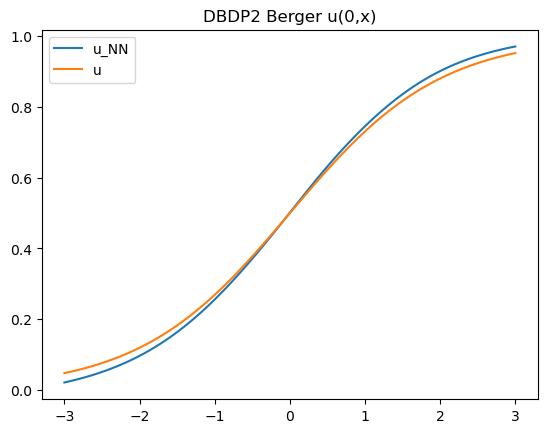

In [52]:
x = torch.linspace(-3,3,100)
u_hat = torch.squeeze(trained_U[0](torch.unsqueeze(x,1)))
u = true_u(t[0],x)
import matplotlib.pyplot as plt
plt.plot(x,u_hat.detach().numpy(),label = "u_NN")
plt.plot(x,u,label = "u")
plt.title("DBDP2 Berger u(0,x)")
plt.legend()
plt.plot()

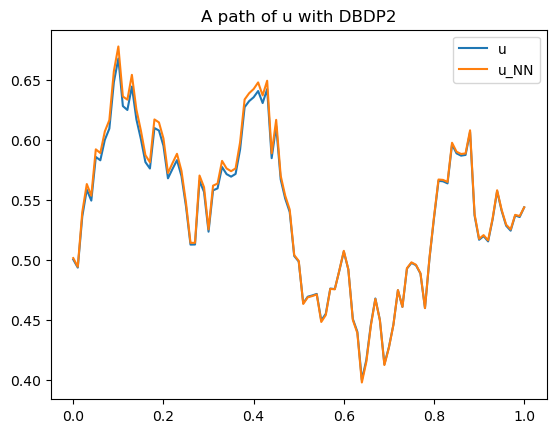

In [56]:
import matplotlib.pyplot as pltb
plt.plot(t,u,label = "u")
plt.plot(t,pred_u.detach().numpy(),label = "u_NN")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.title("A path of u with DBDP2")
# To load the display window
plt.show()

In [53]:
N =1
BM_1 = torch.sqrt(dt) * np.random.normal(size = (N,len(t)-1))
X_1 = torch.zeros((N,len(t))) 
X_1[:,0] = 0
pred_u = torch.zeros(len(t))
u = torch.zeros(len(t))

u[0]= true_u(t[0],X_1[:,0])
pred_u[0] = torch.squeeze(trained_U[0](X_1[:,0]))
for i in range(1,len(t)):
    X_1[:,i] = X_1[:,i-1] + BM_1[:,i-1] 
    # true u(t_i,x_i)
    u[i] = true_u(t[i],X_1[:,i])
    pred_u[i] = torch.squeeze(trained_U[i](X_1[:,i]))